<a href="https://colab.research.google.com/github/camillefougere/PredictivePolicingCaseStudy/blob/main/predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install geopandas

     |████████████████████████████████| 972kB 8.4MB/s 
     |████████████████████████████████| 14.8MB 319kB/s 
     |████████████████████████████████| 6.5MB 17.6MB/s 


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
# import geopandas
from shapely.geometry import Point
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing import sequence
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
import folium
% matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

pd.options.mode.chained_assignment = None

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# a function for creating dummy variables for each zip code and populating them with the number of crimes per day
# need this to transform data into suitable for model input
def expand_dummies(df, date_col, num_col):
  df = pd.get_dummies(df[[date_col, 'ZIPCODE', num_col]])
  df.reset_index(inplace=True)
  for row_num in range(len(df)):
    for col_num in df.columns[1:]:
      if df.loc[row_num, col_num] == 1:
        df.loc[row_num,col_num] = df.loc[row_num,num_col]
  df.drop(columns='index', inplace=True)
  df[date_col] = pd.to_datetime(df[date_col])
  df = df.groupby(date_col).sum().reset_index()
  return df

In [ ]:
# import and process data for Part 1 Crimes Jan 2012 and Part 2 Crimes Jan 2012
jan1 = pd.read_csv('/gdrive/MyDrive/capstone/part1crimesjanuary.csv')
jan1.drop(columns=['Unnamed: 0', 'index'], inplace=True)
jan1 = jan1[jan1['ZIPCODE']!='missi']
display(jan1.head(1))

jan1_grouped = jan1.groupby(['Date Rptd', 'ZIPCODE', 'Part 1-2']).size().reset_index(name='# CRIMES OCCD')
jan1_grouped['Date Rptd'] = pd.to_datetime(jan1_grouped['Date Rptd'])
display(jan1_grouped.head(5))

df1 = expand_dummies(jan1_grouped, 'Date Rptd','# CRIMES OCCD')
display(df1.head(5))

jan2 = pd.read_csv('/gdrive/MyDrive/capstone/part2crimesjanuary.csv')
jan2.drop(columns=['Unnamed: 0', 'index'], inplace=True)
jan2 = jan2[jan2['ZIPCODE']!='missi']
display(jan2.head(1))

jan2_grouped = jan2.groupby(['Date Rptd', 'ZIPCODE', 'Part 1-2']).size().reset_index(name='# CRIMES OCCD')
jan2_grouped['Date Rptd'] = pd.to_datetime(jan2_grouped['Date Rptd'])
display(jan2_grouped.head(5))

df2 = expand_dummies(jan2_grouped, 'Date Rptd', '# CRIMES OCCD')
display(df2.head(5))

,Date Rptd,Part 1-2,COORDINATES,ZIPCODE
0,2012-01-01,1,"34.0091, -118.2915",90037


,Date Rptd,ZIPCODE,Part 1-2,# CRIMES OCCD
0,2012-01-01,90001,1,1
1,2012-01-01,90003,1,5
2,2012-01-01,90004,1,2
3,2012-01-01,90006,1,3
4,2012-01-01,90007,1,1


,Date Rptd,# CRIMES OCCD,ZIPCODE_90001,ZIPCODE_90002,ZIPCODE_90003,ZIPCODE_90004,ZIPCODE_90005,ZIPCODE_90006,ZIPCODE_90007,ZIPCODE_90008,ZIPCODE_90010,ZIPCODE_90011,ZIPCODE_90012,ZIPCODE_90013,ZIPCODE_90014,ZIPCODE_90015,ZIPCODE_90016,ZIPCODE_90017,ZIPCODE_90018,ZIPCODE_90019,ZIPCODE_90020,ZIPCODE_90021,ZIPCODE_90022,ZIPCODE_90023,ZIPCODE_90024,ZIPCODE_90025,ZIPCODE_90026,ZIPCODE_90027,ZIPCODE_90028,ZIPCODE_90029,ZIPCODE_90031,ZIPCODE_90032,ZIPCODE_90033,ZIPCODE_90034,ZIPCODE_90035,ZIPCODE_90036,ZIPCODE_90037,ZIPCODE_90038,ZIPCODE_90039,ZIPCODE_90040,...,ZIPCODE_91306,ZIPCODE_91307,ZIPCODE_91311,ZIPCODE_91312,ZIPCODE_91316,ZIPCODE_91324,ZIPCODE_91325,ZIPCODE_91326,ZIPCODE_91328,ZIPCODE_91330,ZIPCODE_91331,ZIPCODE_91335,ZIPCODE_91340,ZIPCODE_91342,ZIPCODE_91343,ZIPCODE_91344,ZIPCODE_91345,ZIPCODE_91352,ZIPCODE_91356,ZIPCODE_91364,ZIPCODE_91365,ZIPCODE_91367,ZIPCODE_91401,ZIPCODE_91402,ZIPCODE_91403,ZIPCODE_91406,ZIPCODE_91411,ZIPCODE_91423,ZIPCODE_91436,ZIPCODE_91504,ZIPCODE_91522,ZIPCODE_91601,ZIPCODE_91602,ZIPCODE_91604,ZIPCODE_91605,ZIPCODE_91606,ZIPCODE_91607,ZIPCODE_91608,ZIPCODE_91744,ZIPCODE_91754
0,2012-01-01,144,1,0,5,2,0,3,1,3,0,5,4,4,1,1,3,1,3,1,3,4,0,3,0,0,0,0,7,3,3,2,3,0,0,2,6,1,0,0,...,1,0,0,0,0,3,0,0,1,0,3,0,0,5,1,2,1,1,0,0,0,2,4,2,1,1,1,0,0,0,0,2,0,1,2,1,0,0,0,0
1,2012-01-02,197,2,1,4,2,2,1,1,2,0,8,1,0,0,3,4,3,2,2,0,1,0,0,0,7,2,3,2,4,1,1,1,3,2,0,8,0,0,0,...,0,0,1,0,2,0,2,1,0,0,3,0,0,3,3,3,2,0,0,0,0,3,6,2,4,2,0,4,0,0,0,2,1,0,0,2,0,0,0,0
2,2012-01-03,217,0,6,3,2,2,1,4,3,1,5,5,1,1,1,2,0,9,2,1,1,0,3,0,2,0,2,7,2,4,1,1,3,1,2,4,0,0,0,...,1,2,1,0,0,2,2,2,2,0,4,2,0,1,1,2,0,1,3,2,4,3,2,4,3,2,0,1,0,0,0,3,2,0,3,1,0,0,0,0
3,2012-01-04,276,1,1,5,3,2,7,3,4,1,9,1,2,2,1,2,1,2,3,2,2,0,3,0,3,3,1,6,2,1,1,2,3,1,2,9,1,2,1,...,5,1,3,1,2,5,2,0,2,0,2,1,0,2,3,5,3,2,3,2,0,2,8,6,2,3,0,2,1,1,0,9,1,2,1,0,1,0,0,0
4,2012-01-05,242,2,5,7,1,2,3,2,2,1,4,0,2,2,1,2,2,0,2,0,3,0,3,0,3,3,1,3,4,2,3,3,0,4,2,4,0,2,0,...,2,0,2,1,5,2,1,1,0,0,3,1,0,2,1,4,0,5,3,2,0,2,4,1,3,3,3,1,0,0,0,3,0,1,2,0,0,3,0,1


,Date Rptd,Part 1-2,COORDINATES,ZIPCODE
0,2012-01-01,2,"34.0453, -118.2214",90033


,Date Rptd,ZIPCODE,Part 1-2,# CRIMES OCCD
0,2012-01-01,90002,2,2
1,2012-01-01,90003,2,1
2,2012-01-01,90004,2,1
3,2012-01-01,90006,2,3
4,2012-01-01,90007,2,3


,Date Rptd,# CRIMES OCCD,ZIPCODE_90001,ZIPCODE_90002,ZIPCODE_90003,ZIPCODE_90004,ZIPCODE_90005,ZIPCODE_90006,ZIPCODE_90007,ZIPCODE_90008,ZIPCODE_90010,ZIPCODE_90011,ZIPCODE_90012,ZIPCODE_90013,ZIPCODE_90014,ZIPCODE_90015,ZIPCODE_90016,ZIPCODE_90017,ZIPCODE_90018,ZIPCODE_90019,ZIPCODE_90020,ZIPCODE_90021,ZIPCODE_90023,ZIPCODE_90024,ZIPCODE_90025,ZIPCODE_90026,ZIPCODE_90027,ZIPCODE_90028,ZIPCODE_90029,ZIPCODE_90031,ZIPCODE_90032,ZIPCODE_90033,ZIPCODE_90034,ZIPCODE_90035,ZIPCODE_90036,ZIPCODE_90037,ZIPCODE_90038,ZIPCODE_90039,ZIPCODE_90041,ZIPCODE_90042,...,ZIPCODE_91312,ZIPCODE_91316,ZIPCODE_91324,ZIPCODE_91325,ZIPCODE_91326,ZIPCODE_91328,ZIPCODE_91330,ZIPCODE_91331,ZIPCODE_91335,ZIPCODE_91340,ZIPCODE_91342,ZIPCODE_91343,ZIPCODE_91344,ZIPCODE_91345,ZIPCODE_91352,ZIPCODE_91356,ZIPCODE_91364,ZIPCODE_91365,ZIPCODE_91367,ZIPCODE_91401,ZIPCODE_91402,ZIPCODE_91403,ZIPCODE_91405,ZIPCODE_91406,ZIPCODE_91411,ZIPCODE_91423,ZIPCODE_91436,ZIPCODE_91504,ZIPCODE_91506,ZIPCODE_91522,ZIPCODE_91601,ZIPCODE_91602,ZIPCODE_91604,ZIPCODE_91605,ZIPCODE_91606,ZIPCODE_91607,ZIPCODE_91608,ZIPCODE_91723,ZIPCODE_91744,ZIPCODE_91803
0,2012-01-01,171,0,2,1,1,0,3,3,2,1,7,3,4,1,2,2,1,1,4,0,1,3,2,0,0,3,8,4,0,1,5,0,0,3,4,1,0,1,1,...,0,0,2,1,0,0,0,9,1,1,1,1,0,2,0,1,1,0,0,10,2,4,0,2,0,0,0,0,0,0,2,0,0,6,1,0,1,0,0,0
1,2012-01-02,159,0,0,3,1,0,8,0,1,0,5,0,5,2,1,3,1,2,1,1,0,0,3,0,3,0,6,5,0,0,1,0,2,0,1,1,1,4,1,...,0,0,1,1,0,0,1,3,1,0,2,1,1,1,1,3,0,2,2,1,5,2,0,0,4,1,0,0,0,0,4,1,3,1,2,0,0,0,0,0
2,2012-01-03,173,0,5,3,1,1,1,0,3,1,3,2,4,0,1,5,2,2,1,0,0,1,4,1,3,0,2,1,2,2,0,2,1,2,2,0,2,1,1,...,0,1,1,0,1,0,0,8,2,1,1,5,1,1,1,2,1,1,0,5,5,1,0,0,2,0,0,0,0,0,6,4,1,3,2,0,1,0,0,0
3,2012-01-04,176,1,3,3,4,2,3,1,2,0,4,0,2,0,0,2,4,3,4,1,0,0,2,2,3,0,6,3,0,5,2,3,0,1,2,0,0,1,0,...,1,1,1,0,1,1,0,4,4,0,1,3,1,0,4,3,0,1,0,8,4,4,0,3,1,0,1,0,0,0,2,3,1,3,0,0,0,0,0,0
4,2012-01-05,166,0,6,2,1,2,5,1,0,1,3,1,0,1,1,1,1,2,2,0,2,2,1,0,2,2,5,4,1,1,1,2,1,1,1,2,0,1,2,...,0,2,3,0,0,1,0,2,0,1,1,2,3,1,1,4,0,0,2,5,1,1,0,7,1,2,0,0,0,0,3,0,1,1,2,1,0,0,0,0


In [ ]:
# get correlation between # part 1 and # part 2 crimes per zip
from scipy.stats import pearsonr
summed_part1 = jan1_grouped.groupby('ZIPCODE').sum().reset_index()
summed_part1.drop(columns=['Part 1-2'], inplace=True)
summed_part1.rename(columns={'# CRIMES OCCD':'# PART 1 CRIMES REPORTED'}, inplace=True)
summed_part2 = jan2_grouped.groupby('ZIPCODE').sum().reset_index()
summed_part2.drop(columns=['Part 1-2'], inplace=True)
summed_part2.rename(columns={'# CRIMES OCCD':'# PART 2 CRIMES REPORTED'}, inplace=True)
summed = pd.merge(left=summed_part1, right=summed_part2, how='outer', on='ZIPCODE')
summed.fillna(0, inplace=True)
display(summed)
ranked = summed
avg1 = round(np.mean(ranked['# PART 1 CRIMES REPORTED']))
avg2 = round(np.mean(ranked['# PART 2 CRIMES REPORTED']))
ranked['# PART 1 CRIMES REPORTED/AVG'] = ranked['# PART 1 CRIMES REPORTED']/avg1
ranked['# PART 2 CRIMES REPORTED/AVG'] = ranked['# PART 2 CRIMES REPORTED']/avg2
ranked['PROPORTIONAL DIFF'] = -(ranked['# PART 1 CRIMES REPORTED/AVG']-ranked['# PART 2 CRIMES REPORTED/AVG'])
ranked['% DIFF'] = abs(ranked['# PART 1 CRIMES REPORTED/AVG']-ranked['# PART 2 CRIMES REPORTED/AVG'])/((ranked['# PART 1 CRIMES REPORTED']+ranked['# PART 2 CRIMES REPORTED'])/2)
ranked.sort_values(by='PROPORTIONAL DIFF', ascending=False, inplace=True)
ranked.reset_index(inplace=True)
display(ranked[['ZIPCODE', '# PART 1 CRIMES REPORTED', '# PART 2 CRIMES REPORTED', 'PROPORTIONAL DIFF']])
# for i in range(len(ranked)):
#   display(ranked.loc[i])
# display(ranked)


print('COVARIANCE MATRIX FOR # PART 1 and # PART 2 CRIMES REPORTED: ')
print('_____________________________________________________________________')
display(summed.cov())
print('')
print('CORRELATION FOR # PART 1 and # PART 2 CRIMES REPORTED: ')
print('_____________________________________________________________________')
corr_coeff, pval = pearsonr(summed['# PART 1 CRIMES REPORTED'], summed['# PART 2 CRIMES REPORTED'])
print('Correlation Coefficient btw # PART 1 and # PART 2 CRIMES REPORTED: ' + str(corr_coeff))
print('P-Value for Correlation btw # PART 1 and # PART 2 CRIMES REPORTED: ' + str(pval))
if pval < 0.05:
  print('Correlation btw # PART 1 and # PART 2 CRIMES REPORTED: Very high significant')
print('')

# print('MOST DIFFERENT ZIPCODES: ')

,ZIPCODE,# PART 1 CRIMES REPORTED,# PART 2 CRIMES REPORTED
0,90001,26.0,16.0
1,90002,121.0,108.0
2,90003,173.0,113.0
3,90004,93.0,62.0
4,90005,74.0,55.0
...,...,...,...
159,91204,0.0,4.0
160,91405,0.0,1.0
161,91506,0.0,1.0
162,91723,0.0,1.0


,ZIPCODE,# PART 1 CRIMES REPORTED,# PART 2 CRIMES REPORTED,PROPORTIONAL DIFF
0,91401,182.0,170.0,1.094595
1,91331,198.0,179.0,1.030146
2,90057,117.0,118.0,0.939189
3,90008,122.0,120.0,0.897089
4,91402,101.0,103.0,0.841476
...,...,...,...,...
159,90731,165.0,91.0,-0.713617
160,90045,113.0,52.0,-0.767672
161,90037,180.0,95.0,-0.893971
162,90064,161.0,71.0,-1.177235


COVARIANCE MATRIX FOR # PART 1 and # PART 2 CRIMES REPORTED: 
_____________________________________________________________________


,index,# PART 1 CRIMES REPORTED,# PART 2 CRIMES REPORTED,# PART 1 CRIMES REPORTED/AVG,# PART 2 CRIMES REPORTED/AVG,PROPORTIONAL DIFF,% DIFF
index,2255.000000,-694.981595,-443.923313,-13.365031,-11.997927,1.367103,0.225789
# PART 1 CRIMES REPORTED,-694.981595,2630.003442,1884.740162,50.576989,50.938923,0.361934,-0.340317
# PART 2 CRIMES REPORTED,-443.923313,1884.740162,1536.556449,36.245003,41.528553,5.283550,-0.246757
# PART 1 CRIMES REPORTED/AVG,-13.365031,50.576989,36.245003,0.972634,0.979595,0.006960,-0.006545
# PART 2 CRIMES REPORTED/AVG,-11.997927,50.938923,41.528553,0.979595,1.122393,0.142799,-0.006669
PROPORTIONAL DIFF,1.367103,0.361934,5.283550,0.006960,0.142799,0.135838,-0.000125
% DIFF,0.225789,-0.340317,-0.246757,-0.006545,-0.006669,-0.000125,0.000198



CORRELATION FOR # PART 1 and # PART 2 CRIMES REPORTED: 
_____________________________________________________________________
Correlation Coefficient btw # PART 1 and # PART 2 CRIMES REPORTED: 0.9375599920574694
P-Value for Correlation btw # PART 1 and # PART 2 CRIMES REPORTED: 3.344385327092054e-76
Correlation btw # PART 1 and # PART 2 CRIMES REPORTED: Very high significant



In [ ]:
# create a list of dfs from one where each is an expanding window of time
def structure_ts(df):
  dfs = []
  for i in range(1, len(df)+1):
    dfs.append(df[:i])
  return dfs

# check that function returns the right amount of dataframes
display(len(structure_ts(df1)))
display(len(df1))
# display(structure_ts(df1))

31

31

In [ ]:
# extract the time series data for each zipcode in a dataframe
def extract_zip_ts(df, col):
  zipcols = []
  for i in df.columns:
    if i != 'Date Rptd' and i != col:
      zipcols.append(df[['Date Rptd', i]])
  # display(zipcols[0].columns[1]) # how to access what zipcode you're looking for
  return zipcols

# check that extract_zip_ts returns the right amount of zip lists
display(len(extract_zip_ts(df1, '# CRIMES OCCD')))
display(len(df1.columns)-2)
# display(extract_zip_ts(df1, '# CRIMES OCCD')[0]['Date Rptd'])

155

155

In [ ]:
# implement predictive model:
# will need to predict how many crimes for each zip code for each time step:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.api as sm
from pylab import *


def check_seasonal(df):
    datetime_index = pd.DatetimeIndex(df['Date Rptd'])
    df2=df.set_index(datetime_index)
    rcParams['figure.figsize'] = (10, 7)
    print('                           # CRIMES REPORTED IN JANUARY COMPONENTS')
    sm.tsa.seasonal_decompose(df2['# CRIMES OCCD']).plot()
    result = sm.tsa.stattools.adfuller(df2['# CRIMES OCCD'])
    plt.show()
# check_seasonal(df1)

# USING HOLT WINTERS METHOD ADDITITIVE
def get_predictions(data, col):
  dfs = structure_ts(data) # get a dataframe for every day of time range
  total_preds = [] # make a list to fill with the dataframes of predictions for each of ^
  for df in dfs[1:]: # for every dataframe in list (STARTING PREDICTIONS AFTER 2 WEEKS OF DATA)
    zipcols = extract_zip_ts(df, col) # extract ts data for zipcodes from columns
    predictions = pd.DataFrame(columns=['Predicted Date','ZIPCODE', '# CRIMES PRED']) # create a dataframe to hold predictions
    for i in range(len(zipcols)): # for each zipcode in dataframe
      last_date = zipcols[i][zipcols[i].columns[0]][len(zipcols[i][zipcols[i].columns[0]])-1]+pd.Timedelta(1, 'day')  # get last data available
      crimes = zipcols[i][zipcols[i].columns[1]] # get ts version of # crimes
      model = ExponentialSmoothing(np.asarray(crimes), seasonal_periods=7) # make model
      model_fit = model.fit() # fit model
      prediction = round(model_fit.predict()[0]) # predict # crimes for zipcode for next day
      new_row = {'Predicted Date':last_date,'ZIPCODE':zipcols[i].columns[1][8:], '# CRIMES PRED':round(model_fit.predict()[0])}
      predictions = predictions.append(new_row, ignore_index=True)
    total_preds.append(predictions)
  # combine all predictions into one dataframe
  pred = pd.DataFrame()
  for i in total_preds:
    pred = pred.append(i)
  return pred

# calculate rmse
# def get_RMSE(actual, predicted):

In [ ]:
# get predictions ONLY from crimes that actually occurred
df1_pred = get_predictions(df1, '# CRIMES OCCD')
display(df1_pred)
df1_pred_expanded = expand_dummies(df1_pred, 'Predicted Date','# CRIMES PRED')
df1_pred_expanded.reset_index()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:924: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:929: RuntimeWarning: invalid value encountered in double_scalars
  aicc = aic + aicc_penalty
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:930: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)


,Predicted Date,ZIPCODE,# CRIMES PRED
0,2012-01-03,90001,1.0
1,2012-01-03,90002,0.0
2,2012-01-03,90003,5.0
3,2012-01-03,90004,2.0
4,2012-01-03,90005,1.0
...,...,...,...
150,2012-02-01,91606,2.0
151,2012-02-01,91607,1.0
152,2012-02-01,91608,1.0
153,2012-02-01,91744,0.0


,index,Predicted Date,# CRIMES PRED,ZIPCODE_90001,ZIPCODE_90002,ZIPCODE_90003,ZIPCODE_90004,ZIPCODE_90005,ZIPCODE_90006,ZIPCODE_90007,ZIPCODE_90008,ZIPCODE_90010,ZIPCODE_90011,ZIPCODE_90012,ZIPCODE_90013,ZIPCODE_90014,ZIPCODE_90015,ZIPCODE_90016,ZIPCODE_90017,ZIPCODE_90018,ZIPCODE_90019,ZIPCODE_90020,ZIPCODE_90021,ZIPCODE_90022,ZIPCODE_90023,ZIPCODE_90024,ZIPCODE_90025,ZIPCODE_90026,ZIPCODE_90027,ZIPCODE_90028,ZIPCODE_90029,ZIPCODE_90031,ZIPCODE_90032,ZIPCODE_90033,ZIPCODE_90034,ZIPCODE_90035,ZIPCODE_90036,ZIPCODE_90037,ZIPCODE_90038,ZIPCODE_90039,...,ZIPCODE_91306,ZIPCODE_91307,ZIPCODE_91311,ZIPCODE_91312,ZIPCODE_91316,ZIPCODE_91324,ZIPCODE_91325,ZIPCODE_91326,ZIPCODE_91328,ZIPCODE_91330,ZIPCODE_91331,ZIPCODE_91335,ZIPCODE_91340,ZIPCODE_91342,ZIPCODE_91343,ZIPCODE_91344,ZIPCODE_91345,ZIPCODE_91352,ZIPCODE_91356,ZIPCODE_91364,ZIPCODE_91365,ZIPCODE_91367,ZIPCODE_91401,ZIPCODE_91402,ZIPCODE_91403,ZIPCODE_91406,ZIPCODE_91411,ZIPCODE_91423,ZIPCODE_91436,ZIPCODE_91504,ZIPCODE_91522,ZIPCODE_91601,ZIPCODE_91602,ZIPCODE_91604,ZIPCODE_91605,ZIPCODE_91606,ZIPCODE_91607,ZIPCODE_91608,ZIPCODE_91744,ZIPCODE_91754
0,0,2012-01-03,150.0,1.0,0.0,5.0,2.0,1.0,2.0,1.0,3.0,0.0,6.0,2.0,2.0,0.0,2.0,3.0,2.0,3.0,1.0,2.0,2.0,0.0,2.0,0.0,3.0,1.0,1.0,4.0,3.0,2.0,1.0,2.0,1.0,1.0,1.0,7.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,4.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,2.0,2.0,1.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,1,2012-01-04,194.0,1.0,6.0,3.0,2.0,2.0,1.0,2.0,3.0,0.0,6.0,3.0,2.0,1.0,2.0,3.0,1.0,5.0,2.0,1.0,1.0,0.0,2.0,0.0,3.0,1.0,2.0,5.0,3.0,3.0,1.0,1.0,3.0,1.0,1.0,6.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,2.0,2.0,2.0,1.0,0.0,3.0,1.0,0.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,3.0,4.0,3.0,3.0,2.0,0.0,2.0,0.0,0.0,0.0,2.0,2.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0
2,2,2012-01-05,240.0,1.0,2.0,4.0,2.0,2.0,3.0,2.0,3.0,1.0,7.0,3.0,2.0,1.0,2.0,3.0,1.0,4.0,3.0,1.0,2.0,0.0,2.0,0.0,3.0,1.0,2.0,5.0,3.0,2.0,1.0,2.0,3.0,1.0,1.0,7.0,0.0,0.0,...,2.0,1.0,3.0,0.0,1.0,2.0,2.0,1.0,1.0,0.0,3.0,1.0,0.0,2.0,2.0,3.0,2.0,1.0,3.0,2.0,1.0,2.0,5.0,6.0,3.0,3.0,0.0,2.0,0.0,0.0,0.0,9.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
3,3,2012-01-06,240.0,1.0,3.0,5.0,2.0,2.0,3.0,2.0,3.0,1.0,6.0,2.0,2.0,1.0,1.0,3.0,1.0,3.0,2.0,1.0,3.0,0.0,2.0,0.0,3.0,2.0,1.0,5.0,3.0,2.0,2.0,3.0,0.0,2.0,2.0,6.0,0.0,2.0,...,2.0,1.0,2.0,1.0,4.0,2.0,1.0,1.0,1.0,0.0,3.0,1.0,0.0,2.0,2.0,3.0,1.0,5.0,3.0,2.0,1.0,2.0,5.0,3.0,3.0,3.0,1.0,2.0,0.0,0.0,0.0,4.0,0.0,1.0,2.0,1.0,0.0,1.0,0.0,0.0
4,4,2012-01-07,227.0,1.0,3.0,4.0,2.0,4.0,3.0,2.0,3.0,2.0,6.0,2.0,2.0,1.0,1.0,3.0,1.0,3.0,2.0,2.0,2.0,0.0,3.0,0.0,3.0,1.0,1.0,5.0,3.0,2.0,2.0,5.0,2.0,5.0,2.0,6.0,1.0,1.0,...,2.0,1.0,2.0,0.0,2.0,2.0,1.0,1.0,1.0,0.0,3.0,1.0,0.0,1.0,3.0,3.0,1.0,3.0,2.0,0.0,1.0,3.0,4.0,3.0,2.0,2.0,6.0,2.0,0.0,0.0,0.0,3.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0
5,5,2012-01-08,231.0,1.0,3.0,4.0,2.0,2.0,3.0,2.0,3.0,1.0,6.0,2.0,3.0,1.0,2.0,7.0,1.0,3.0,3.0,2.0,2.0,0.0,2.0,0.0,3.0,1.0,1.0,5.0,3.0,2.0,5.0,2.0,2.0,2.0,2.0,6.0,1.0,1.0,...,2.0,1.0,1.0,0.0,2.0,2.0,0.0,1.0,1.0,0.0,3.0,3.0,1.0,3.0,3.0,3.0,1.0,4.0,3.0,1.0,1.0,3.0,4.0,3.0,2.0,4.0,3.0,2.0,0.0,0.0,0.0,4.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0
6,6,2012-01-09,232.0,1.0,3.0,5.0,2.0,2.0,4.0,2.0,3.0,2.0,5.0,2.0,2.0,1.0,2.0,3.0,1.0,3.0,3.0,2.0,2.0,0.0,2.0,0.0,3.0,2.0,1.0,6.0,3.0,2.0,2.0,2.0,2.0,1.0,2.0,6.0,1.0,1.0,...,2.0,1.0,2.0,0.0,2.0,2.0,0.0,1.0,1.0,0.0,3.0,2.0,0.0,6.0,3.0,3.0,1.0,5.0,1.0,1.0,1.0,3.0,4.0,2.0,2.0,3.0,4.0,2.0,0.0,0.0,0.0,4.0,1.0,1.0,2.0,1.0,0.0,1.0,0.0,0.0
7,7,2012-01-10,251.0,1.0,3.0,5.0,2.0,2.0,3.0,2.0,3.0,1.0,5.0,2.0,2.0,1.0,2.0,3.0,1.0,3.0,2.0,2.0,2.0,0.0,3.0,0.0,2.0,2.0,1.0,6.0,4.0,2.0,2.0,2.0,2.0,1.0,2.0,5.0,1.0,1.0,...,4.0,1.0,2.0,0.0,2.0,2.0,2.0,1.0,1.0,0.0,11.0,2.0,0.0,3.0,3.0,3.0,1.0,2.0,2.0,1.0,1.0,3.0,4.0,3.0,2.0,5.0,3.0,2.0,0.0,0.0,0.0,3.0,1.0,1.0,2.0,3.0,0.0,1.0,0.0,0.0
8,8,2012-01-11,244.0,1.0,3.0,5.0,1.0,2.0,4.0,2.0,3.0,1.0,5.0,3.0,2.0,1.0,2.0,4.0,1.0,3.0,2.0,2.0,2.0,0.0,2.0,3.0,2.0,3.0,1.0,6.0,4.0,2.0,2.0,2.0,2.0,2.0,3.0,5.0,1.0,1.0,...,2.0,1.0,4.0,0.0,2.0,2.0,2.0,1.0,1.0,0.0,9.0,

In [ ]:
df1_pred_grouped = df1_pred.groupby('ZIPCODE').sum().reset_index()

In [ ]:
# add
pred_added = pd.merge(left=jan1_grouped, right=df1_pred, left_on=['Date Rptd', 'ZIPCODE'], right_on=['Predicted Date','ZIPCODE']).drop(columns='Predicted Date')
# add "totals"
totals = []
for i in range(len(pred_added)):
  if pred_added.loc[i, '# CRIMES PRED'] >= 5:
    totals.append(round(pred_added.loc[i, '# CRIMES OCCD']*1.2))
  else:
    totals.append(pred_added.loc[i, '# CRIMES OCCD'])
pred_added.insert(len(pred_added.columns), '# CRIMES TOTAL', totals)
display(pred_added)
pred_added_expanded = expand_dummies(pred_added, 'Date Rptd', '# CRIMES TOTAL')
pred_added_expanded.reset_index()
display(pred_added_expanded)
pred_disc = get_predictions(pred_added_expanded, '# CRIMES TOTAL')
display(pred_disc)

,Date Rptd,ZIPCODE,Part 1-2,# CRIMES OCCD,# CRIMES PRED,# CRIMES TOTAL
0,2012-01-03,90002,1,6,0.0,6.0
1,2012-01-03,90003,1,3,5.0,4.0
2,2012-01-03,90004,1,2,2.0,2.0
3,2012-01-03,90005,1,2,1.0,2.0
4,2012-01-03,90006,1,1,2.0,1.0
...,...,...,...,...,...,...
2829,2012-01-31,91436,1,1,1.0,1.0
2830,2012-01-31,91601,1,4,4.0,4.0
2831,2012-01-31,91605,1,2,3.0,2.0
2832,2012-01-31,91607,1,1,0.0,1.0


,Date Rptd,# CRIMES TOTAL,ZIPCODE_90001,ZIPCODE_90002,ZIPCODE_90003,ZIPCODE_90004,ZIPCODE_90005,ZIPCODE_90006,ZIPCODE_90007,ZIPCODE_90008,ZIPCODE_90010,ZIPCODE_90011,ZIPCODE_90012,ZIPCODE_90013,ZIPCODE_90014,ZIPCODE_90015,ZIPCODE_90016,ZIPCODE_90017,ZIPCODE_90018,ZIPCODE_90019,ZIPCODE_90020,ZIPCODE_90021,ZIPCODE_90022,ZIPCODE_90023,ZIPCODE_90024,ZIPCODE_90025,ZIPCODE_90026,ZIPCODE_90027,ZIPCODE_90028,ZIPCODE_90029,ZIPCODE_90031,ZIPCODE_90032,ZIPCODE_90033,ZIPCODE_90034,ZIPCODE_90035,ZIPCODE_90036,ZIPCODE_90037,ZIPCODE_90038,ZIPCODE_90039,ZIPCODE_90040,...,ZIPCODE_91306,ZIPCODE_91307,ZIPCODE_91311,ZIPCODE_91312,ZIPCODE_91316,ZIPCODE_91324,ZIPCODE_91325,ZIPCODE_91326,ZIPCODE_91328,ZIPCODE_91330,ZIPCODE_91331,ZIPCODE_91335,ZIPCODE_91340,ZIPCODE_91342,ZIPCODE_91343,ZIPCODE_91344,ZIPCODE_91345,ZIPCODE_91352,ZIPCODE_91356,ZIPCODE_91364,ZIPCODE_91365,ZIPCODE_91367,ZIPCODE_91401,ZIPCODE_91402,ZIPCODE_91403,ZIPCODE_91406,ZIPCODE_91411,ZIPCODE_91423,ZIPCODE_91436,ZIPCODE_91504,ZIPCODE_91522,ZIPCODE_91601,ZIPCODE_91602,ZIPCODE_91604,ZIPCODE_91605,ZIPCODE_91606,ZIPCODE_91607,ZIPCODE_91608,ZIPCODE_91744,ZIPCODE_91754
0,2012-01-03,221.0,0.0,6.0,4.0,2.0,2.0,1.0,4.0,3.0,1.0,6.0,5.0,1.0,1.0,1.0,2.0,0.0,9.0,2.0,1.0,1.0,0.0,3.0,0.0,2.0,0.0,2.0,7.0,2.0,4.0,1.0,1.0,3.0,1.0,2.0,5.0,0.0,0.0,0.0,...,1.0,2.0,1.0,0.0,0.0,2.0,2.0,2.0,2.0,0.0,4.0,2.0,0.0,1.0,1.0,2.0,0.0,1.0,3.0,2.0,4.0,3.0,2.0,4.0,3.0,2.0,0.0,1.0,0.0,0.0,0.0,3.0,2.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0
1,2012-01-04,283.0,1.0,1.0,5.0,3.0,2.0,7.0,3.0,4.0,1.0,11.0,1.0,2.0,2.0,1.0,2.0,1.0,2.0,3.0,2.0,2.0,0.0,3.0,0.0,3.0,3.0,1.0,7.0,2.0,1.0,1.0,2.0,3.0,1.0,2.0,11.0,1.0,2.0,1.0,...,5.0,1.0,3.0,1.0,2.0,5.0,2.0,0.0,2.0,0.0,2.0,1.0,0.0,2.0,3.0,5.0,3.0,2.0,3.0,2.0,0.0,2.0,8.0,6.0,2.0,3.0,0.0,2.0,1.0,1.0,0.0,9.0,1.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0
2,2012-01-05,252.0,2.0,5.0,7.0,1.0,2.0,3.0,2.0,2.0,1.0,5.0,0.0,2.0,2.0,1.0,2.0,2.0,0.0,2.0,0.0,3.0,0.0,3.0,0.0,3.0,3.0,1.0,4.0,4.0,2.0,3.0,3.0,0.0,4.0,2.0,5.0,0.0,2.0,0.0,...,2.0,0.0,2.0,1.0,5.0,2.0,1.0,1.0,0.0,0.0,3.0,1.0,0.0,2.0,1.0,4.0,0.0,5.0,3.0,2.0,0.0,2.0,5.0,1.0,3.0,3.0,3.0,1.0,0.0,0.0,0.0,4.0,0.0,1.0,2.0,0.0,0.0,3.0,0.0,1.0
3,2012-01-06,248.0,1.0,5.0,1.0,1.0,4.0,5.0,1.0,4.0,2.0,5.0,2.0,2.0,1.0,2.0,4.0,2.0,2.0,2.0,5.0,0.0,0.0,4.0,0.0,1.0,1.0,1.0,7.0,4.0,3.0,3.0,5.0,1.0,5.0,4.0,6.0,7.0,0.0,0.0,...,3.0,2.0,2.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,3.0,2.0,1.0,1.0,8.0,3.0,2.0,4.0,2.0,0.0,0.0,5.0,1.0,1.0,0.0,2.0,6.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0
4,2012-01-07,237.0,1.0,3.0,3.0,2.0,1.0,3.0,3.0,4.0,1.0,7.0,0.0,8.0,1.0,3.0,7.0,0.0,3.0,4.0,0.0,2.0,0.0,0.0,0.0,5.0,1.0,1.0,8.0,5.0,0.0,5.0,2.0,2.0,2.0,2.0,8.0,0.0,2.0,0.0,...,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,0.0,3.0,3.0,1.0,7.0,3.0,0.0,1.0,4.0,3.0,2.0,0.0,3.0,1.0,3.0,2.0,5.0,2.0,1.0,0.0,0.0,0.0,6.0,2.0,1.0,2.0,3.0,0.0,0.0,0.0,0.0
5,2012-01-08,254.0,1.0,3.0,10.0,1.0,3.0,5.0,1.0,3.0,2.0,2.0,6.0,1.0,0.0,1.0,1.0,0.0,1.0,3.0,3.0,0.0,0.0,3.0,0.0,1.0,3.0,1.0,13.0,2.0,0.0,1.0,1.0,1.0,1.0,3.0,2.0,0.0,1.0,0.0,...,3.0,1.0,2.0,1.0,2.0,0.0,0.0,0.0,2.0,0.0,7.0,2.0,0.0,6.0,3.0,5.0,2.0,5.0,1.0,0.0,4.0,4.0,5.0,1.0,2.0,3.0,5.0,2.0,0.0,0.0,0.0,2.0,0.0,2.0,2.0,2.0,0.0,3.0,1.0,0.0
6,2012-01-09,290.0,2.0,5.0,7.0,1.0,4.0,3.0,0.0,2.0,1.0,6.0,2.0,1.0,1.0,2.0,3.0,0.0,2.0,1.0,1.0,2.0,0.0,4.0,1.0,0.0,3.0,2.0,11.0,6.0,2.0,2.0,1.0,5.0,1.0,3.0,5.0,2.0,2.0,0.0,...,6.0,0.0,2.0,0.0,6.0,3.0,2.0,4.0,2.0,0.0,11.0,2.0,0.0,2.0,2.0,4.0,0.0,0.0,7.0,2.0,1.0,4.0,5.0,4.0,0.0,6.0,2.0,3.0,1.0,0.0,0.0,3.0,1.0,2.0,2.0,3.0,1.0,0.0,0.0,0.0
7,2012-01-10,276.0,1.0,2.0,5.0,1.0,1.0,5.0,0.0,7.0,1.0,2.0,5.0,2.0,1.0,1.0,8.0,1.0,7.0,4.0,1.0,3.0,0.0,0.0,3.0,3.0,4.0,2.0,5.0,6.0,2.0,3.0,4.0,4.0,2.0,3.0,7.0,2.0,2.0,0.0,...,0.0,0.0,5.0,0.0,1.0,4.0,2.0,1.0,1.0,0.0,11.0,5.0,1.0,2.0,1.0,2.0,2.0,1.0,3.0,0.0,1.0,4.0,10.0,3.0,1.0,1.0,1.0,4.0,0.0,0.0,0.0,3.0,1.0,0.0,6.0,2.0,0.0,2.0,0.0,0.0
8,2012-01-11,270.0,0.0,6.0,5.0,4.0,2.0,4.0,1.0,7.0,0.0,1.0,1.0,1.0,0.0,1.0,8.0,0.0,6.0,2.0,1.0,1.0,0.0,2.0,0.0,2.0,3.0,0.0,5.0,2.0,1.0,4.0,3.0,3.0,1.0,4.0,4.0,1.0,1.0,0.0,...,4.0,0.0,1.0,0.0

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:924: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:929: RuntimeWarning: invalid value encountered in double_scalars
  aicc = aic + aicc_penalty
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:930: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


,Predicted Date,ZIPCODE,# CRIMES PRED
0,2012-01-05,90001,0.0
1,2012-01-05,90002,3.0
2,2012-01-05,90003,4.0
3,2012-01-05,90004,2.0
4,2012-01-05,90005,2.0
...,...,...,...
150,2012-02-01,91606,2.0
151,2012-02-01,91607,1.0
152,2012-02-01,91608,1.0
153,2012-02-01,91744,0.0


In [ ]:
pred_disc_grouped = pred_disc.groupby('ZIPCODE').sum().reset_index()
display(max(pred_disc_grouped[1:]['# CRIMES PRED']))

287.0

,ZIPCODE,# CRIMES PRED
0,90001,30.0
1,90002,108.0
2,90003,147.0
3,90004,87.0
4,90005,61.0
...,...,...
150,91606,51.0
151,91607,1.0
152,91608,25.0
153,91744,0.0


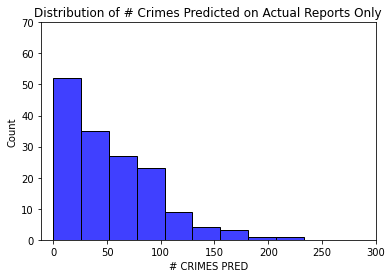

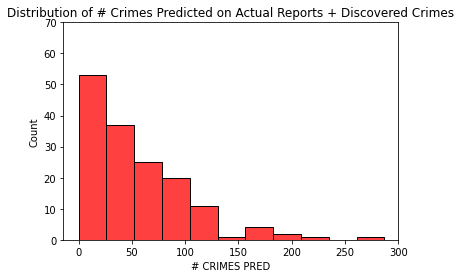




Stats for Crimes Predicted Across Zipcodes Based Only on Actual Reports:
_____________________________________________________________________________
Mean: 49.303225806451614
Range: 0.0, 233.0
Standard Deviation: 46.7903180215941
Variance: 2189.333860561914



Stats for Crimes Predicted Across Zipcodes Based on Actual Reports and "Discovered" Crimes:
_____________________________________________________________________________
Mean: 49.883870967741935
Range: 0.0, 287.0
Standard Deviation: 50.251747501465985
Variance: 2525.238126951093


In [ ]:
display(df1_pred_grouped)
sns.histplot(x=df1_pred_grouped['# CRIMES PRED'], color='blue')
plt.title('Distribution of # Crimes Predicted on Actual Reports Only')
plt.ylim(ymax=70)
plt.xlim(xmax=300)
plt.show()
sns.histplot(x=pred_disc_grouped['# CRIMES PRED'], color='red')
plt.title('Distribution of # Crimes Predicted on Actual Reports + Discovered Crimes')
plt.ylim(ymax=70)
plt.xlim(xmax=300)
plt.show()

print('')
print('')
print('')
print('Stats for Crimes Predicted Across Zipcodes Based Only on Actual Reports:')
print('_____________________________________________________________________________')
print('Mean: ' + str(np.mean(df1_pred_grouped['# CRIMES PRED'])))
print('Range: ' + str(np.min(df1_pred_grouped['# CRIMES PRED'])) + ', ' + str(np.max(df1_pred_grouped['# CRIMES PRED'])))
print('Standard Deviation: ' + str(np.std(df1_pred_grouped['# CRIMES PRED'])))
print('Variance: ' + str(np.var(df1_pred_grouped['# CRIMES PRED'])))

print('')
print('')
print('')
print('Stats for Crimes Predicted Across Zipcodes Based on Actual Reports and "Discovered" Crimes:')
print('_____________________________________________________________________________')
print('Mean: ' + str(np.mean(pred_disc_grouped['# CRIMES PRED'])))
print('Range: ' + str(np.min(pred_disc_grouped['# CRIMES PRED'])) + ', ' + str(np.max(pred_disc_grouped['# CRIMES PRED'])))
print('Standard Deviation: ' + str(np.std(pred_disc_grouped['# CRIMES PRED'])))
print('Variance: ' + str(np.var(pred_disc_grouped['# CRIMES PRED'])))

In [ ]:
# display(pred_added_expanded)
# df1_lim = df1[2:]
# display(df1_lim)

def calc_RMSE(df1, df2):
  rmses = pd.DataFrame(columns=['Date', 'Prediction RMSE'])
  # print(df1)
  # print(df2)
  for i in range(len(df1)):
    list1 = (df1.loc[i].tolist()[3:])
    list2 = (df2.loc[i].tolist()[3:])
    mse = mean_squared_error(list1, list2)
    rmse = math.sqrt(mse)
    date = df1.loc[i].tolist()[1]
    rmses = rmses.append({'Date':date, 'Prediction RMSE':rmse}, ignore_index=True)
  return rmses

# pred_added_expanded.reset_index(inplace=True)
# df1_lim.reset_index(inplace=True)
RMSES = calc_RMSE(df1_lim, pred_added_expanded)
RMSES

,Date,Prediction RMSE
0,2012-01-03,1.427834
1,2012-01-04,1.616448
2,2012-01-05,1.441326
3,2012-01-06,1.515511
4,2012-01-07,1.393533
5,2012-01-08,1.681014
6,2012-01-09,1.713325
7,2012-01-10,1.663653
8,2012-01-11,1.472325
9,2012-01-12,1.752418


In [ ]:
RMSES

[1.4278339110062328,
 1.616447718240974,
 1.4413255547719641,
 1.5155111987538683,
 1.393533452727622,
 1.6810135191642281,
 1.7133253838567097,
 1.6636531896654034,
 1.472325349738933,
 1.7524176847816515,
 1.5155111987538683,
 1.4569079055181526,
 1.2128345896846295,
 1.7468866314749238,
 1.3319885691653277,
 1.9493588689617927,
 1.962552649797148,
 1.3725417908908768,
 1.2313119150962784,
 1.365472859134248,
 1.7301873849663725,
 1.5533522542573697,
 1.6905811178790067,
 1.4502502564907935,
 1.5303383560085553,
 1.545023227719748,
 1.1832159566199232,
 1.5408418310738765,
 1.5261167249147478]

In [ ]:
# visualize where crimes are predicted to happen based only off historical data
for day in pred_added['Date Rptd'].unique():
  day_df = pred_added[pred_added['Date Rptd'] <= day]
  zipped = (day_df.groupby(['ZIPCODE']).sum().reset_index())
  day_str =(day.astype(str)[:10]) + '_part1predicted'
  create_map(zipped, 'ZIPCODE', '# CRIMES PRED', day_str)

In [ ]:
for day in pred_disc['Predicted Date'].unique():
  day_df = pred_disc[pred_disc['Predicted Date'] <= day]
  zipped = (day_df.groupby(['ZIPCODE']).sum().reset_index())
  day_str =(day.astype(str)[:10]) + '_part1predicted_with_discovery'
  create_map(zipped, 'ZIPCODE', '# CRIMES PRED', day_str)

In [ ]:
def create_map(data, zipcodes, mapped_feature, add_text):
  json = r'/gdrive/MyDrive/capstone/updated-file.json'
  m = folium.Map(location = [34.0522, -118.2437], zoom_start = 11, tiles=None)
  folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(m)
  folium.Choropleth(geo_data = json,
                 fill_opacity = 0.7,
                 line_opacity=0.2,
                 data=data,
                 columns = [zipcodes, mapped_feature],
                 key_on = 'feature.properties.name',
                 fill_color='YlGnBu',
                 legend_name=('Crime Across LA: ' + str(add_text))).add_to(m)
  folium.LayerControl().add_to(m)
  m.save(outfile = add_text + mapped_feature + '_map.html')

In [ ]:
for i in df1_pred['From Date'].unique():
  print(df1_pred[df1_pred['From Date']==i])

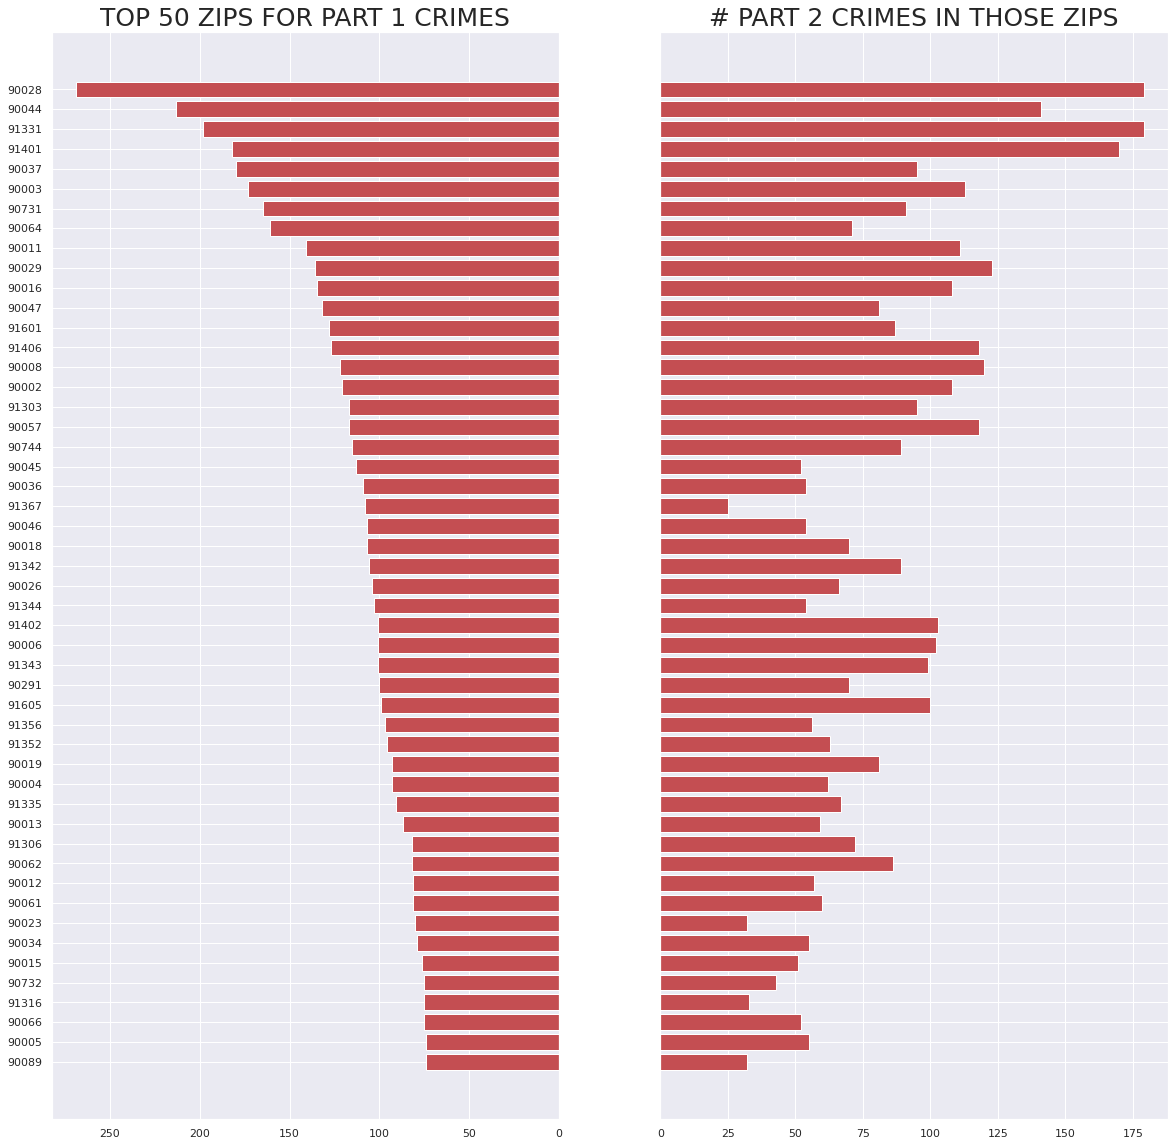

In [ ]:
# visualize geographhic difference between part 1 and part 2 crimes
top_jan1 = jan1_grouped[['ZIPCODE', '# CRIMES OCCD']].groupby('ZIPCODE').sum().reset_index().sort_values(by='# CRIMES OCCD', ascending=False)
top_jan1.rename(columns={'# CRIMES OCCD':'# PART 1 CRIMES'}, inplace=True)
# top_jan1['Part'] = 1
top10_jan1 = top_jan1[:10]
top_jan2 = jan2_grouped[['ZIPCODE', '# CRIMES OCCD']].groupby('ZIPCODE').sum().reset_index().sort_values(by='# CRIMES OCCD', ascending=False)
top_jan2.rename(columns={'# CRIMES OCCD':'# PART 2 CRIMES'}, inplace=True)
# top_jan2['Part'] = 2
top10_jan2 = top_jan2[:10]
top = pd.merge(left=top10_jan1, right=top10_jan2, on='ZIPCODE')
top.sort_values(by='# PART 1 CRIMES', ascending=False, inplace=True)
top
all = pd.merge(left=top_jan1, right=top_jan2, on='ZIPCODE')[:50]
all.sort_values(by='# PART 1 CRIMES', inplace=True)
all

fig, axes = plt.subplots(ncols=2, sharey=True)
fig.set_size_inches(20,20)
axes[0].barh(all['ZIPCODE'], all['# PART 1 CRIMES'], align='center', color='R')
axes[1].barh(all['ZIPCODE'], all['# PART 2 CRIMES'], align='center', color='R')
axes[0].invert_xaxis()
axes[0].set_title('TOP 50 ZIPS FOR PART 1 CRIMES', fontsize=25)
axes[1].set_title('# PART 2 CRIMES IN THOSE ZIPS', fontsize=25)
plt.show()